In [ ]:
from IPython.core.display import HTML, display
display(HTML('<style>.container { width:100%; !important } </style>'))

# Testing Miscellaneous Features

This notebook tests miscellaneous functionality that is not tested by the test notebooks for evaluation, negamax search and alpha-beta pruning. Specifically, this notebook tests features that all search algorithms share, as well as certain functions from the `Game` class.

### Dependencies

In [ ]:
import chess
from IPython.display import clear_output

import import_ipynb
import Game
from AlphaBetaAlgorithm import AlphaBetaPruningPD

### Opening Book Tests

First, we test the integration of the opening book. We take a state in the early game, which is still in the opening book. Therefore, the next move that will be made has to be in the opening book. Because a random move from the opening book is chosen, different moves may be made. Therefore, we test each board state 50 times, making it unlikely that any given move is not made at least once.  
In the end, we compare the moves made to our expected moves. These expected moves were found by manually calling the opening book on the given board state to find the possible moves that it recommends in that position; the AI should make these same moves.

#### perform_opening_tests
This function runs tests for the opening book functionality, using the process described above. It finds the set of moves made across 50 tests and compares it to the set of expected moves. If the sets are identical, the test passes. If not, the test fails. The result of the test is printed.

###### __<u>Arguments</u>__

``fen (str):``  
The FEN code of the board state to be tested.

``expected_moves (set<chess.Move>):``  
The set of moves to expect. This set should be found by manually calling the opening book on the given board state to find the possible moves that it recommends in that position.

In [3]:
def perform_opening_tests(fen: str, expected_moves: set) -> None:
    game = Game.Game(
        algorithm_white=AlphaBetaPruningPD,
        algorithm_black=AlphaBetaPruningPD,
        fen=fen
    )

    made_moves = set()
    for _ in range(50):
        game.make_opening_move()
        move = game.board.pop()
        made_moves.add(move)

    if expected_moves == made_moves:
        print(f'The test PASSED. The game made {made_moves}, which was expected.')
    else:
        print(f'The test FAILED. The game made {made_moves}, but was expected to ' \
                + f'make {expected_moves}')

In the following, the tests for the opening book are performed with three different board states.

In [4]:
perform_opening_tests(
    fen='rnbqkb1r/pppppppp/5n2/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 0 2',
    expected_moves={
        chess.Move.from_uci('e7e6'),
        chess.Move.from_uci('d7d5')
    }
)

The test PASSED. The game made {Move.from_uci('e7e6'), Move.from_uci('d7d5')}, which was expected.


In [5]:
perform_opening_tests(
    fen='rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1', 
    expected_moves={
        chess.Move.from_uci('f7f5'),
        chess.Move.from_uci('d7d6'),
        chess.Move.from_uci('e7e6'),
        chess.Move.from_uci('d7d5'),
        chess.Move.from_uci('g8f6')
    }
)

The test PASSED. The game made {Move.from_uci('d7d5'), Move.from_uci('f7f5'), Move.from_uci('e7e6'), Move.from_uci('g8f6'), Move.from_uci('d7d6')}, which was expected.


In [6]:
perform_opening_tests(
    fen='rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1', 
    expected_moves={
        chess.Move.from_uci('d2d4'),
        chess.Move.from_uci('g1f3'),
        chess.Move.from_uci('e2e4')
    }
)

The test PASSED. The game made {Move.from_uci('d2d4'), Move.from_uci('e2e4'), Move.from_uci('g1f3')}, which was expected.


No move except the opening moves available for the specific board state have been made. Furthermore, all possible opening moves in the opening book for the specified board state have been made at least once. Because all tests passed, we assume that the opening book is integrated correctly.

### Endgame Tablebase Tests

Next, we test the integration of endgame tablebases. First, we define a list of tuples structured `(fen, expected_winner)`, which represent board states that should be available in the endgame tablebases (i.e. there are 5 pieces or fewer on the board), as well as which player has a guaranteed checkmate (or `None` in the case of a draw). The exact pieces as well as the expected results are documented as comments in the code.

In [7]:
endgame_state_list = [
    ('8/3k4/8/3K2R1/8/8/8/8 w - - 0 1', chess.WHITE),   # black: king, white: king, 1 rook
                                                        # -> checkmate for white.
    ('4N3/5K1k/8/8/8/8/3B4/8 w - - 0 1', chess.WHITE),  # black: king, white: king, 1 bishop, 1 knight
                                                        # -> checkmate for white.
    ('4k3/8/8/8/8/8/1N1P4/4K3 w - - 0 1', chess.WHITE), # black: king, white: king, 1 knight, 1 pawn 
                                                        # -> checkmate for white.
    ('8/8/8/7k/8/8/3B4/R3K3 w - - 0 1', chess.WHITE),   # black: king, white: king, 1 rook, 1 bishop
                                                        # -> checkmate for white.
    ('8/1k6/8/8/8/8/5P2/4K3 w - - 0 1', chess.WHITE),   # black: king, white: king, 1 pawn
                                                        # -> checkmate for white.
    ('8/1k6/8/8/8/8/1P6/4K3 w - - 0 1', None),          # black; king, white: king, 1 pawn
                                                        # -> draw.
    ('k7/7p/8/2nKb3/8/8/8/8 w - - 0 1', None),          # black: king, 1 pawn, 1 knight, 1 bishop,
                                                        # white: king
                                                        # -> draw (a 'wrong bishop' scenario).
    ('8/5K1p/1k5b/8/8/8/8/8 w - - 0 1', None),          # black: king, 1 pawn, 1 bishop, white: king
                                                        # -> draw.
    ('8/7p/1k5b/8/8/8/8/2K2R2 w - - 0 1', None),        # black: king, 1 pawn, 1 bishop,
                                                        # white: king, 1 rook
                                                        # -> draw.
    ('2k5/7p/8/5b2/8/6N1/8/2K5 w - - 0 1', None)        # black: king, 1 pawn, 1 bishop,
                                                        # white: king, 1 knight
                                                        # -> draw.
]

To test the endgame tablebase usage, we play a number of games defined through FEN codes in the aforementioned `endgame_state_list`. We use negamax search with alpha-beta pruning, memoization and progressive deepening due to its efficiency. We disable quiescence search to keep the maximum search depth consistent, in order to test if the endgame tablebases allow the search algorithms to identify checkmates or draws far beyond their search depth. For each state, we check if the outcome is what we expect and if the endgame tablebases were used.

#### perform_endgame_tablebase_tests
This function runs the tests for the endgame tablebase integration.  
It iterates through a list of states, playing a game of chess starting at each state using the `AlphaBetaPruningPD` search algorithm with endgame tablebases enabled. Each state has at most 5 pieces on the board, so the endgame tablebases take effect immediately. For each state, it checks if the outcome (checkmate in favor of a specific color or a draw) is as expected. If each state has the correct outcome and the algorithm used the endgame tablebases to achieve that outcome, the tests pass. Otherwise, the tests fail.

###### __<u>Arguments</u>__
``endgame_state_list (list<str>):``   
A list of different board states to test, represented as FEN codes.  

In [8]:
def perform_endgame_tablebase_tests(endgame_state_list: list) -> None:
    test_passed = {}
    for state, outcome in endgame_state_list:
        game = Game.Game(
            algorithm_white=AlphaBetaPruningPD,
            algorithm_black=AlphaBetaPruningPD,
            fen=state
        )
        game.board.update_check_endgame_tablebase() # Set endgame tablebase usage flag.
        game.play()
        for _, _, used_endgame in game.test_playthrough:
            if used_endgame and game.board.outcome().winner == outcome:
                test_passed[state] = True
                break
        else:
            test_passed[state] = False

    clear_output()
    for state, passed in test_passed.items():
        result = 'PASSED' if passed else 'FAILED'
        print(f'Test with state {state} {result}')

In [9]:
perform_endgame_tablebase_tests(endgame_state_list)

Test with state 8/3k4/8/3K2R1/8/8/8/8 w - - 0 1 PASSED
Test with state 4N3/5K1k/8/8/8/8/3B4/8 w - - 0 1 PASSED
Test with state 4k3/8/8/8/8/8/1N1P4/4K3 w - - 0 1 PASSED
Test with state 8/8/8/7k/8/8/3B4/R3K3 w - - 0 1 PASSED
Test with state 8/1k6/8/8/8/8/5P2/4K3 w - - 0 1 PASSED
Test with state 8/1k6/8/8/8/8/1P6/4K3 w - - 0 1 PASSED
Test with state k7/7p/8/2nKb3/8/8/8/8 w - - 0 1 PASSED
Test with state 8/5K1p/1k5b/8/8/8/8/8 w - - 0 1 PASSED
Test with state 8/7p/1k5b/8/8/8/8/2K2R2 w - - 0 1 PASSED
Test with state 2k5/7p/8/5b2/8/6N1/8/2K5 w - - 0 1 PASSED


All tests passed, therefore we assume that the endgame tablebases are integrated correctly.

### Board Representation Tests

Next, we test the representation of board states. Specifically, we test the uniqueness of the internal representation of a board state, which is used in caching. Each board state should be unique (with some minor exceptions that would make caching too inefficient, such as en passant rights and the counter for fivefold repetition). A board state should not have the same internal representation as another board state if they are not identical.  

#### perform_board_state_tests
Runs the tests for verifying the uniqueness of the internal board state representation. As described above, a state should be unique, meaning that different board states should have different representations.

We define an empty list `state_reprs` and iterate through the different board states defined in `state_list`. For each state, we check if its representation already exists in `state_reprs`. If so, it means that the current board state's representation is shared with another board state, indicating a bug and resulting in a failed test. If its representation is not already in `state_reprs`, it is added to said list. The tests pass if each representation is unique. The result of the tests is printed.

###### __<u>Arguments</u>__
``state_list (list<str>):``  
A list of different board states to test, represented as FEN codes. 

In [10]:
def perform_board_state_tests(state_list: list) -> None:
    state_reprs = []

    for state in state_list:
        state_test_game = Game.Game(
            algorithm_white=AlphaBetaPruningPD,
            algorithm_black=AlphaBetaPruningPD,
            fen=state
        )

        state_repr = state_test_game.board.get_state_repr()
        if state_repr in state_reprs: 
            print(f'Tests FAILED - {state} does not have a unique representation')
            return
        state_reprs.append(state_repr)

    print(f'Tests PASSED - each state is unique')

`state_list` is a list of FEN codes representing board states. These states are chosen to be similar in certain aspects, in order to test if the internal representation is different despite these similarities.

In [1]:
state_list = [
    # State A   
    '7r/2B3R1/1P2p3/n1n4p/2r1B2p/2q1k3/2P3Kp/8 w - - 0 1', # White's turn
    '7r/2B3R1/1P2p3/n1n4p/2r1B2p/2q1k3/2P3Kp/8 b - - 0 1', # Black's turn

    # State A'  - White and black pieces are swapped compared to State A
    '7R/2b3r1/1p2P3/N1N4P/2R1b2P/2Q1K3/2p3kP/8 w - - 0 1', # White's turn
    '7R/2b3r1/1p2P3/N1N4P/2R1b2P/2Q1K3/2p3kP/8 b - - 0 1', # Black's turn

    # State B   - Different castling rights 
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R w K - 0 1', # White castling rights (short) 
                                                                     # White's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R b K - 0 1', # White castling rights (short)
                                                                     # Black's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R w Q - 0 1', # White castling rights (long)
                                                                     # White's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R b Q - 0 1', # White castling rights (long)
                                                                     # Black's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R w k - 0 1', # Black castling rights (short)
                                                                     # White's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R b k - 0 1', # Black castling rights (short)
                                                                     # Black's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R w q - 0 1', # Black castling rights (long)
                                                                     # White's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R b q - 0 1', # Black castling rights (long)
                                                                     # Black's turn
    
    # State B'  - No castling rights 
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R w - - 0 1', # White's turn
    'r3k2r/pppqbppp/2nppn2/5b2/2BP4/N3PN2/PPPBQPPP/R3K2R b - - 0 1', # Black's turn

    # State C   
    'b5K1/7p/6p1/2Ppn2P/1b3pR1/Pk1p4/3RQ3/5N2 w - - 2 5', # White's turn
    'b5K1/7p/6p1/2Ppn2P/1b3pR1/Pk1p4/3RQ3/5N2 b - - 2 5', # Black's turn

    # State C'  - Switch white and black kings compared to State C
    'b5k1/7p/6p1/2Ppn2P/1b3pR1/PK1p4/3RQ3/5N2 w - - 2 5', # White's turn
    'b5k1/7p/6p1/2Ppn2P/1b3pR1/PK1p4/3RQ3/5N2 b - - 2 5', # Black's turn

    # State C'' - Remove rook on D2 from State C, rest stays the same
    'b5K1/7p/6p1/2Ppn2P/1b3pR1/Pk1p4/4Q3/5N2 w - - 2 5', # White's turn
    'b5K1/7p/6p1/2Ppn2P/1b3pR1/Pk1p4/4Q3/5N2 b - - 2 5'  # Black's turn
]

In the following, the board state tests are performed using the `state_list` from above.

In [12]:
perform_board_state_tests(state_list)

Tests PASSED - each state is unique


Because all tests passed, we assume that the function `chess.Board.get_state_repr` for representing board states works as intended.

### Saving and Loading Tests

In the following, saving and loading functionality for games is tested. These tests have to be performed manually; they are not automated.  
A game is played for a couple of moves. After that, the execution of the cell is stopped and the game is saved. This simulates a player who does not have enough time to finish the current game they are playing, therefore saving it for later.   
The game is then loaded again with the `playback` parameter set to `True` and `False`. If set to `True`, the user can play back all moves played during the game. If set to `False`, the saved state of the game is simply loaded, and the player can continue where they had left off.  
When a saved state is loaded, the board should be in the same state as it was before. Furthermore, after making the same move in each loaded game, the move and corresponding move score from the AI should always be the same, unless the game is still able to make use of the opening book.

Here, the game is initialized and played. We play for a couple of moves where we capture pieces and lose pieces on purpose. We play a couple of moves after the opening book was not used anymore by the game, to ensure that the search algorithm itself is used and that moves with evaluation scores are saved.

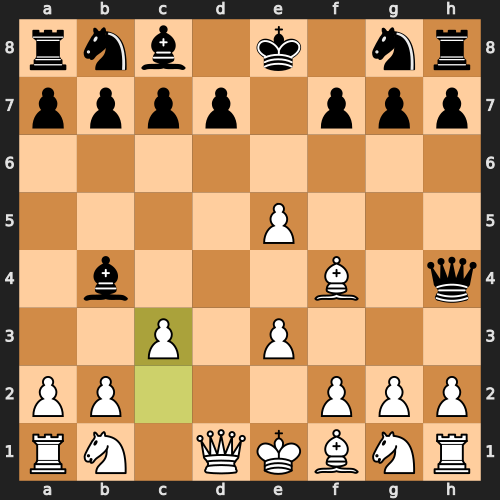

Search time: 5.079996109008789 seconds
Move: c2c3
Predicted move sequence: c2c3, b4c5, g2g4, h4g4
Move score: -140
Used endgame tablebase: False
Board score for white: 130


KeyboardInterrupt: Interrupted by user

In [13]:
state_test_game = Game.Game(algorithm_white=AlphaBetaPruningPD)
state_test_game.play()

We now stop the execution and save the current game state.

In [14]:
state_test_game.save_game()

We now load the previously saved game, with the parameter `playback` set to `False`, so the game immediately starts at our saved state.

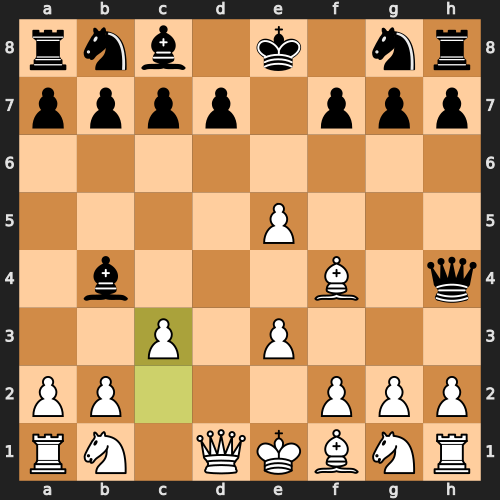

KeyboardInterrupt: Interrupted by user

In [15]:
state_test_game.load_game(playback=False)

As we see, the game starts from the previously saved game state.

Next, we set `playback` to `True`. We are still using the same save file as before. The user must now "click" through the different moves made in the original game. After the game reaches the originally saved state, it has run out of moves to play back and the game expects us to make a move, essentially reaching the same situation as when we set `playback` to `False`.

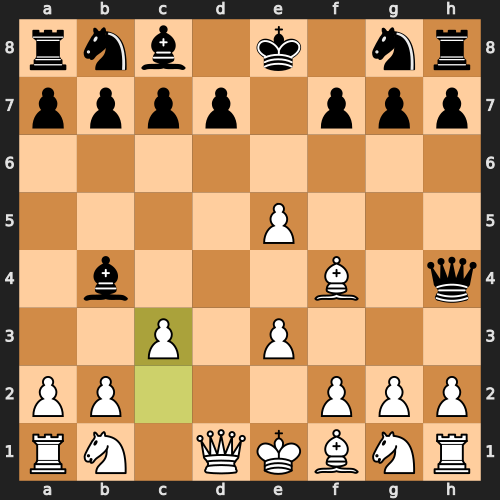

Please input your move: 
Illegal move, please try again: 


KeyboardInterrupt: Interrupted by user

In [16]:
state_test_game.load_game(playback=True)

The game plays back the moves that were made correctly. Furthermore, it correctly asks us to make a move once all previous moves have been played back.

When we make a next move, the search algorithm always responds with the same move and corresponding score in both of these loaded games. Therefore, we can assume that the `playback` parameter does not affect how the game progresses after we make a move. Based on these tests, we also assume that loading a previously saved state works as intended.